In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import os,sys,json
import pandas as pd
import numpy as np
import sklearn
import scipy as scp
import openpyxl
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sktime as skt

# supress this warning
pd.options.mode.chained_assignment = None

print({pkg.__name__:pkg.__version__ for pkg in [pd, np, scp, sklearn, openpyxl, sns, matplotlib, skt]})

{'pandas': '1.3.4', 'numpy': '1.21.6', 'scipy': '1.7.1', 'sklearn': '1.1.1', 'openpyxl': '3.0.9', 'seaborn': '0.11.1', 'matplotlib': '3.4.3', 'sktime': '0.12.0'}


In [3]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')

In [4]:
from ml_pipeline.dataset import load_excel
DATA_PATH = '../input/elevator_failure_prediction.xlsx'

# load the data
raw = load_excel(DATA_PATH, select_sheet='data').set_index('Time')

### Univariate EDA visualisations

In [5]:
from ml_pipeline.plotting import plot_univariate_by_target

#### i) Density plots

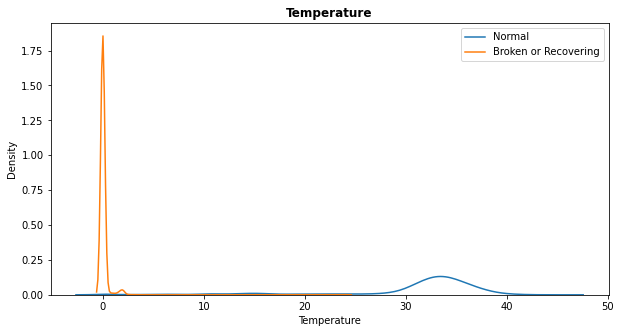

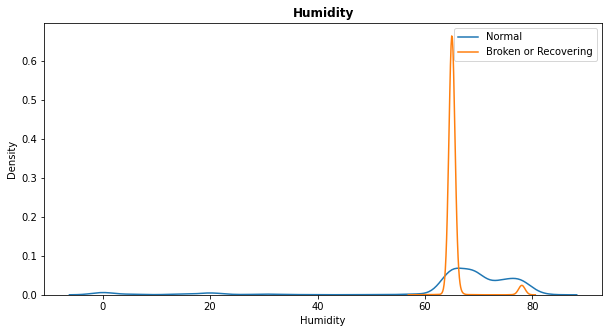

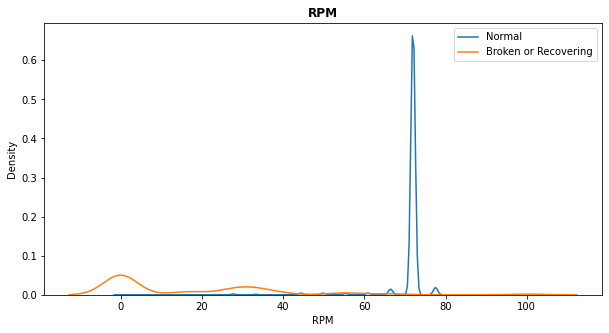

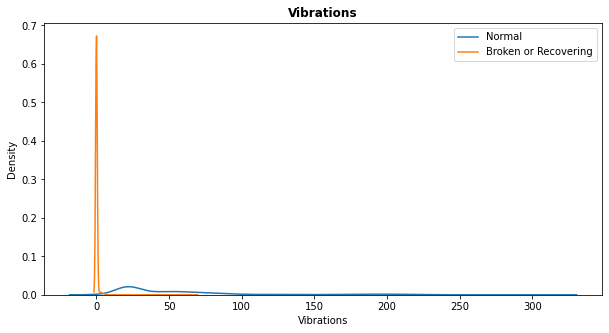

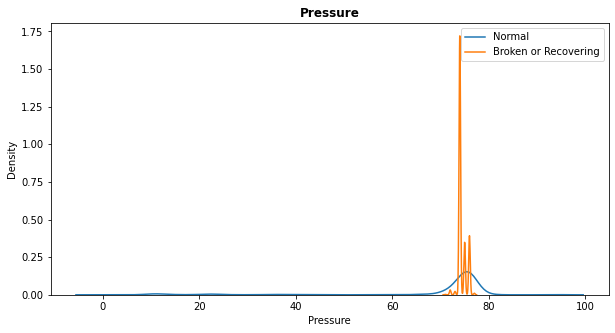

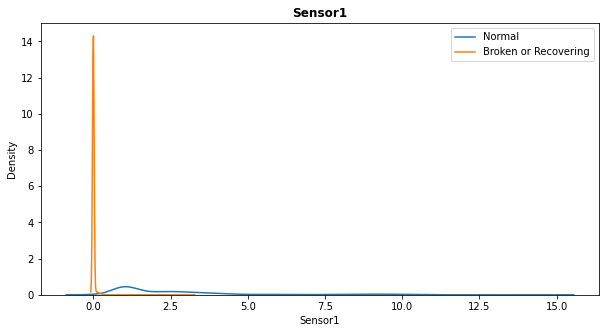

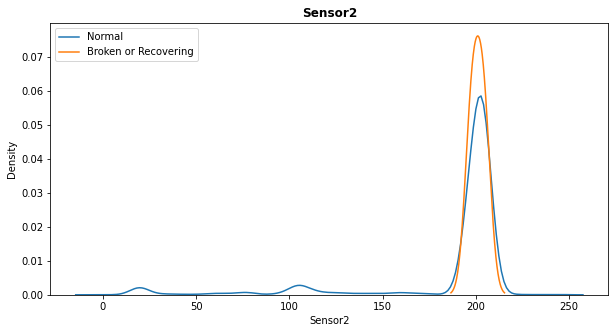

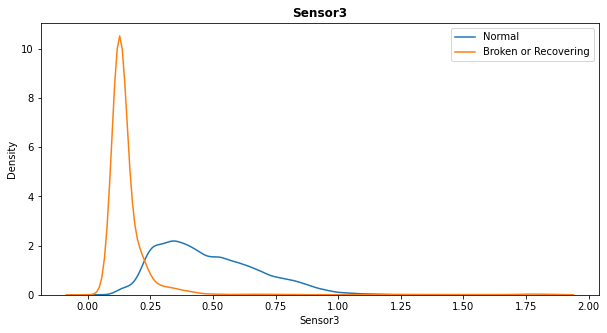

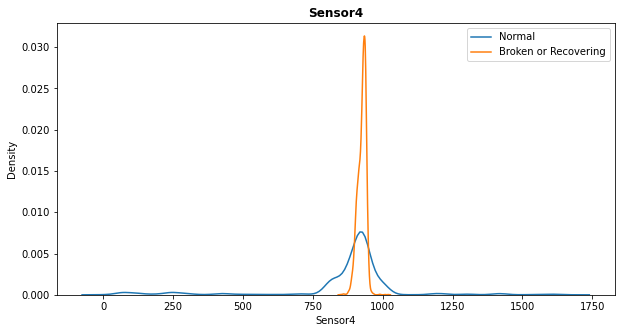

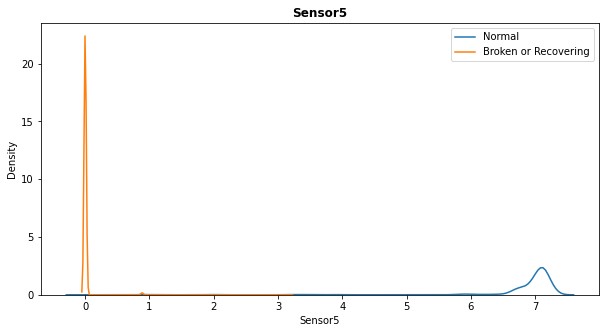

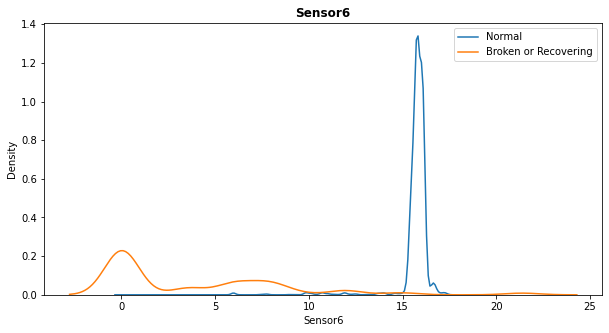

In [6]:
# start by looking at each column individually with respect to target
for c in raw.columns[:-1]:
    plot_univariate_by_target(
                        raw[c], 
                        raw['Status'], 
                        target_groups = {'Normal':[0], 'Broken or Recovering':[1,2]} 
                        )

#### ii) Plot vs time

In [7]:
from ml_pipeline.plotting import plot_univariate_by_target, plot_timeseries_by_target

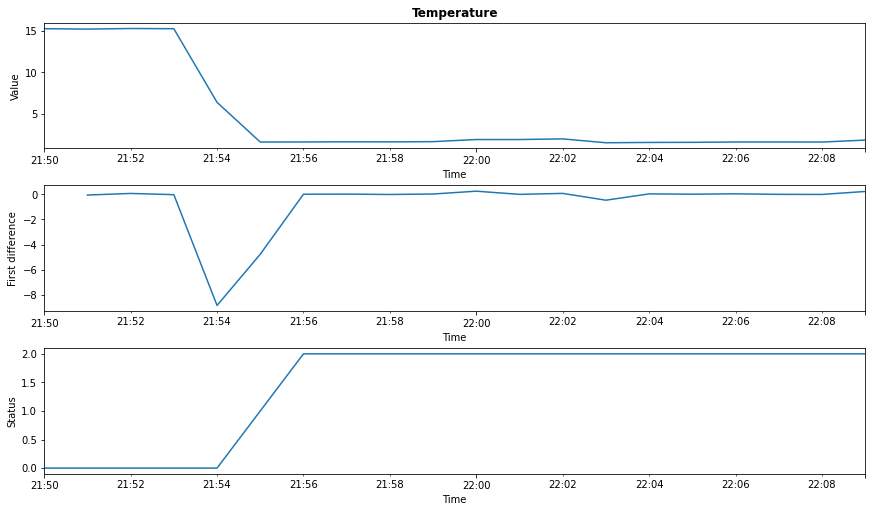

In [8]:
# the zoomed in example shows how the 1 example of 'broke' is followed by 'recovering'
plot_timeseries_by_target(raw.Temperature.iloc[17150:17170], raw.Status.iloc[17150:17170])

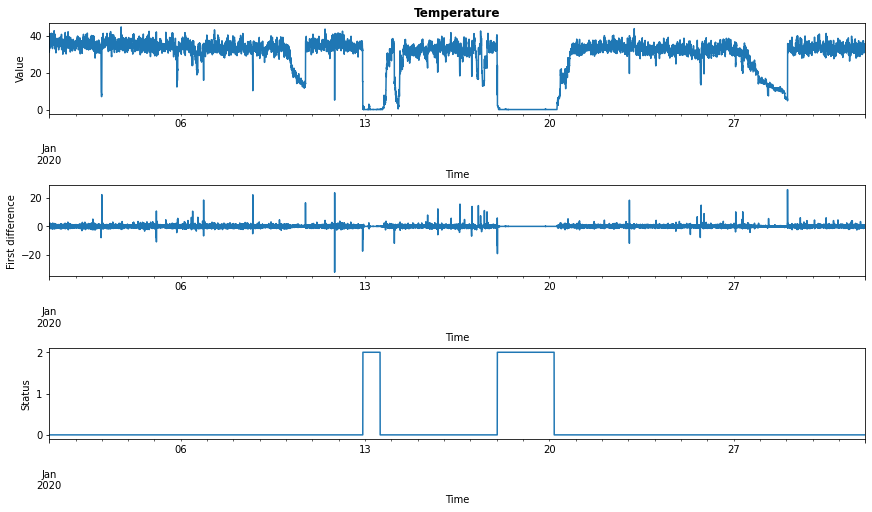

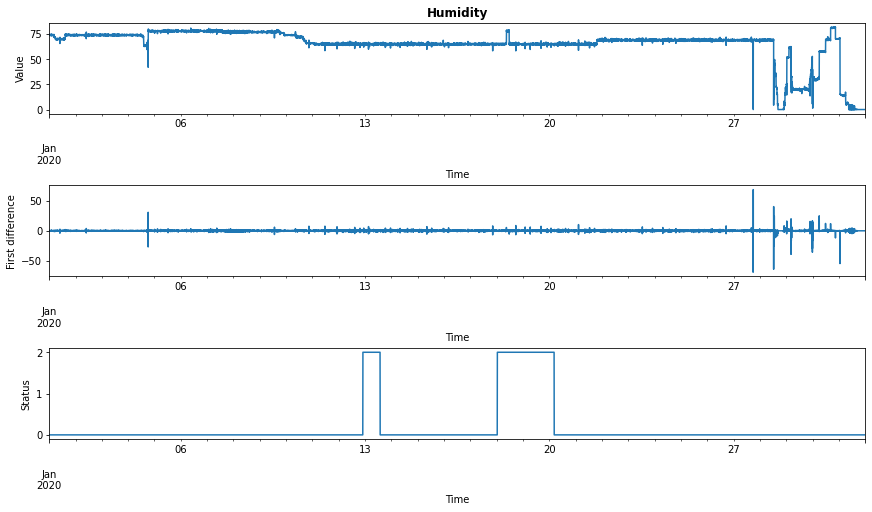

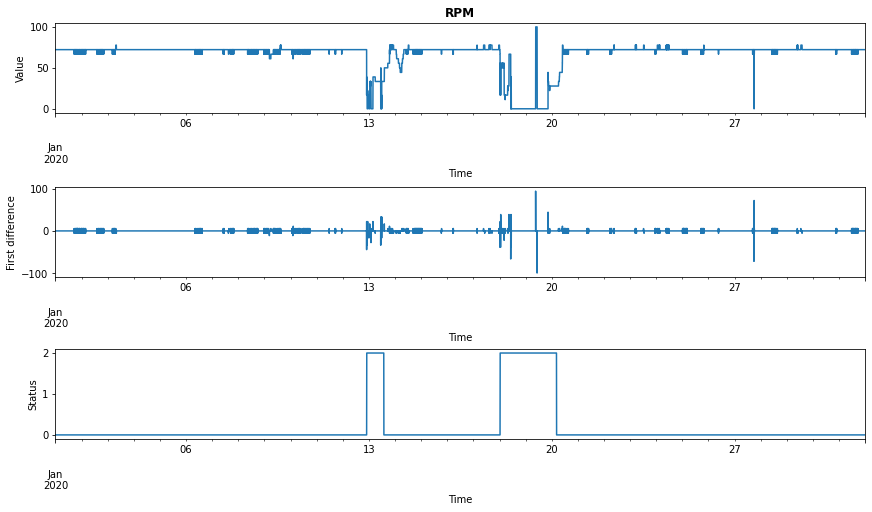

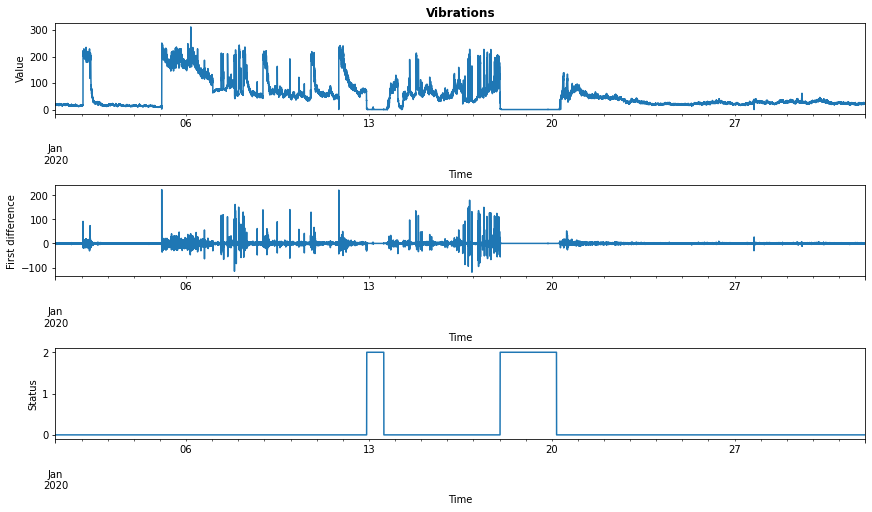

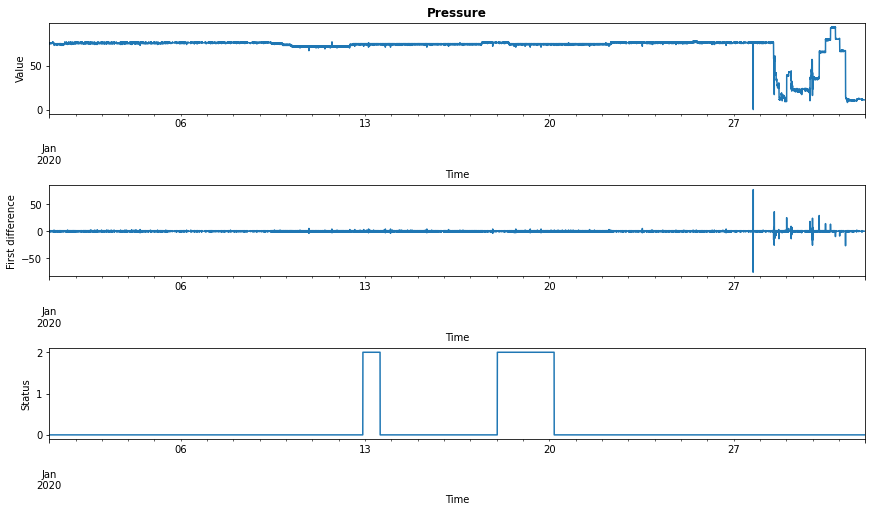

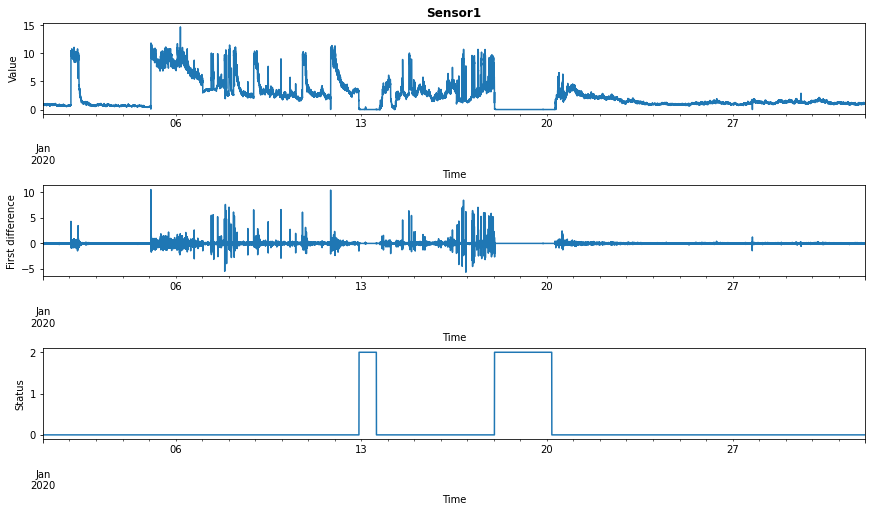

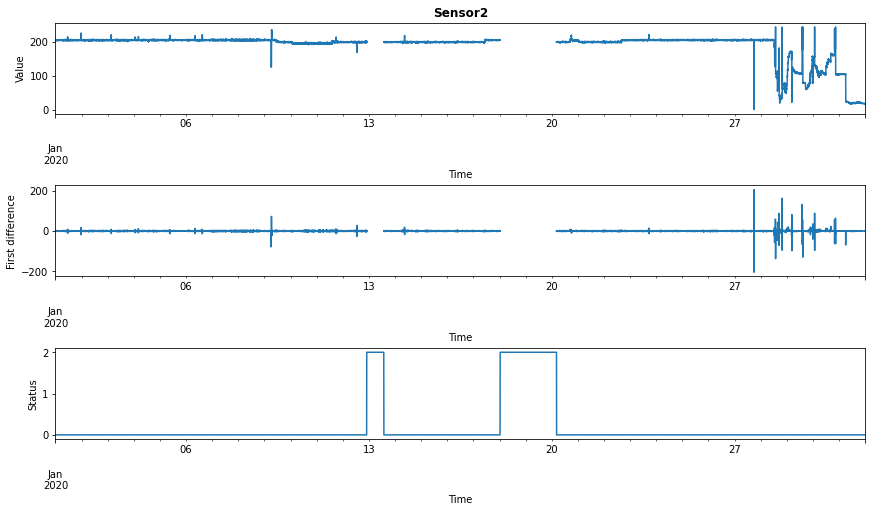

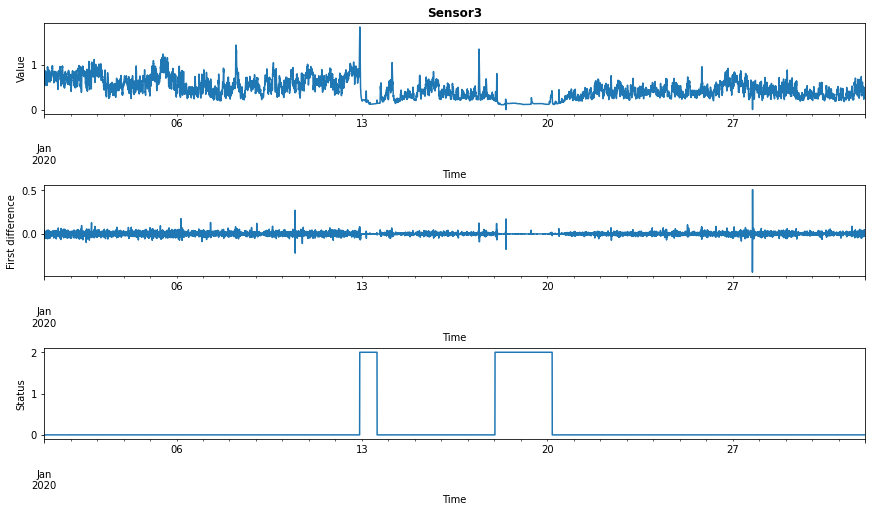

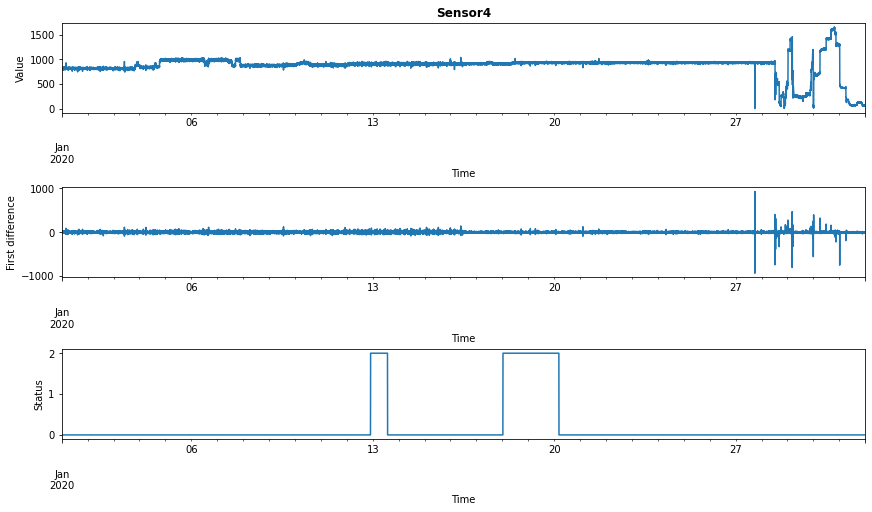

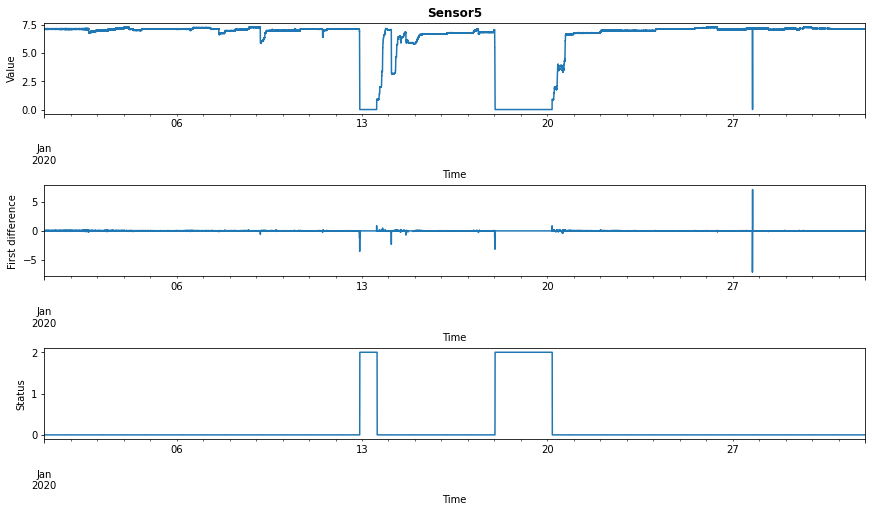

In [9]:
# loop through entire series
# do all of these changes seem real (e.g. temperature spikes)
for c in raw.columns[:-2]:
    plot_timeseries_by_target(raw[c], raw.Status)

### Correlation & dropping features

In [10]:
# this function can be used to add first difference features
from ml_pipeline.dataset import add_first_differences
raw_w_first_diff = add_first_differences(raw)

In [11]:
from ml_pipeline.plotting import plot_correlation_matrix

#### i) Pairwise correlation

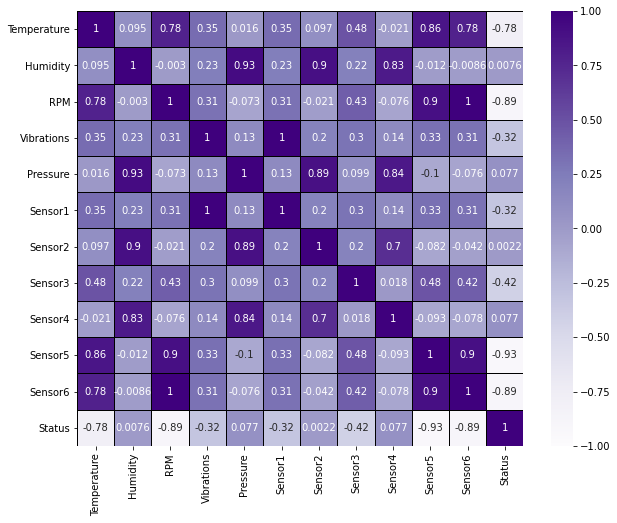

In [12]:
# we can conclude:
# Sensor1 ~= Vibrations (drop?)
# Sensor6 ~= RPM (drop?)
# Sensors 2&4 closely related to Humidity & Pressure
# Sensors 5 closely related to Temperature & RPM
plot_correlation_matrix(raw)

In [13]:
# Similarly Sensor1 is likely a rounded transformation of Vibrations
# we should considering dropping it
print(raw.corr().loc['Vibrations','Sensor1'])
raw[['Vibrations','Sensor1']].head(5)

0.9999999986071603


,Vibrations,Sensor1
Time,,
2020-01-01 00:00:00,16.81,0.791225
2020-01-01 00:01:00,16.81,0.791225
2020-01-01 00:02:00,17.08,0.803988
2020-01-01 00:03:00,15.79,0.743260
2020-01-01 00:04:00,16.84,0.792391


In [14]:
# RPM seems to be a rounded transformation of Sensor6
# we should considering dropping it
print(raw.corr().loc['RPM','Sensor6'])
raw[['RPM','Sensor6']].head(5)

0.9980335313388843


,RPM,Sensor6
Time,,
2020-01-01 00:00:00,72.0,15.842287
2020-01-01 00:01:00,72.0,15.842287
2020-01-01 00:02:00,72.0,15.739743
2020-01-01 00:03:00,72.0,15.731202
2020-01-01 00:04:00,72.0,15.773928


#### ii) pearson vs spearman correlation

- what we normally call 'correlation' is in fact 'Pearson correlation'
- Spearman correlation is a correlation based on rank 
- Pearson(rank(x),rank(y)) = Spearman(x,y)
- Spearman considered more robust for time series cross correlation

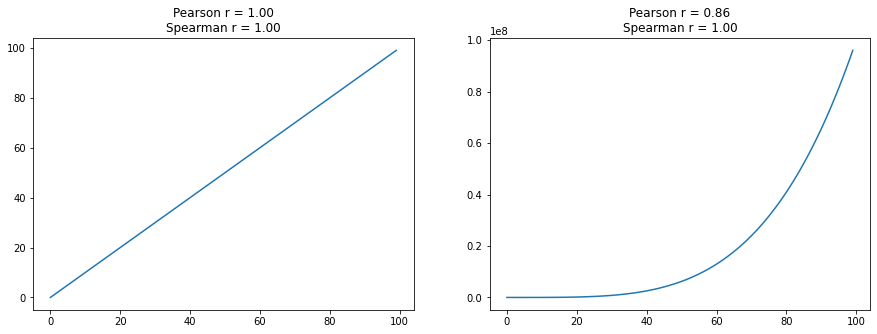

In [15]:
# dummy data example
xs1 = np.arange(100)
ys1 = np.arange(100)
ys2 = ys1**4

from scipy.stats import pearsonr, spearmanr

# visualise difference
fig, axes = plt.subplots(figsize=(15,5), ncols=2)
for idx, ys in enumerate([ys1, ys2]):

    # compute correlation coefficients
    pr, _ = pearsonr(xs1, ys)
    sr, _ = spearmanr(xs1, ys)
    axes[idx].plot(xs1, ys)
    axes[idx].set_title(f'Pearson r = {pr:.2f}\nSpearman r = {sr:.2f}')


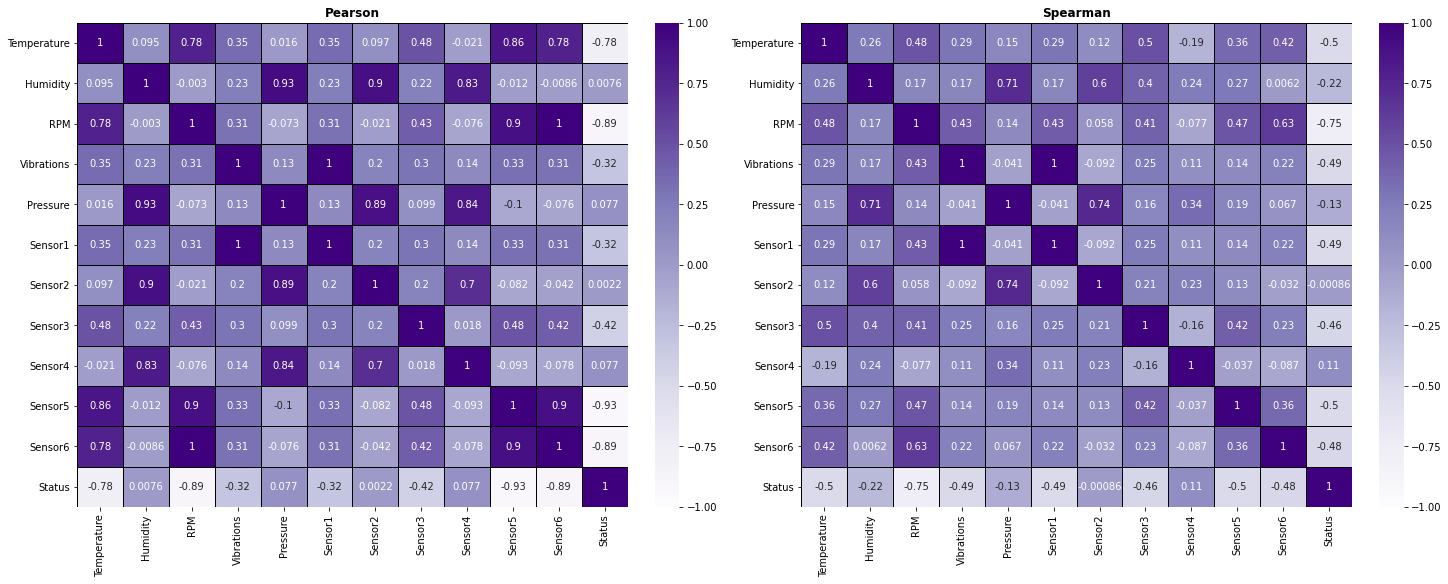

In [16]:
# compare correlation methods
fig, (ax1,ax2) = plt.subplots(figsize=(20,8), ncols=2, constrained_layout=True)
plot_correlation_matrix(raw, method = 'pearson', title='Pearson', ax=ax1)
plot_correlation_matrix(raw, method = 'spearman', title='Spearman', ax=ax2)
# Sensor1 still seems like we should drop it
# but Sensor6 not so much, because it is a more detailed version of RPM

#### iii) cross correlation

- time series values are not independent ('within-series' dependence)
- we remove within-series dependence by correlating differences instead
- example of how you can have strong correlation of values but cross correlation is low

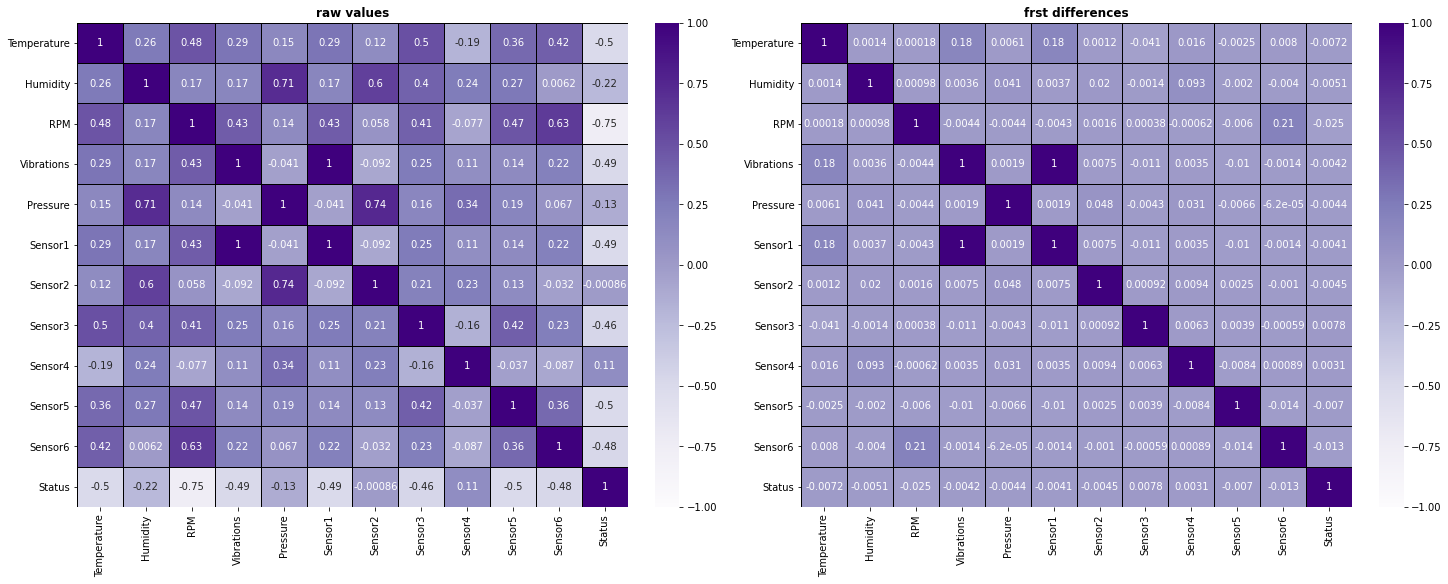

In [17]:
# correlation vs cross-correlation (Spearman)
fig, (ax1,ax2) = plt.subplots(figsize=(20,8), ncols=2, constrained_layout=True)
plot_correlation_matrix(raw, method = 'spearman', title='raw values', ax=ax1)
plot_correlation_matrix(raw.diff(), method = 'spearman', title='frst differences', ax=ax2)

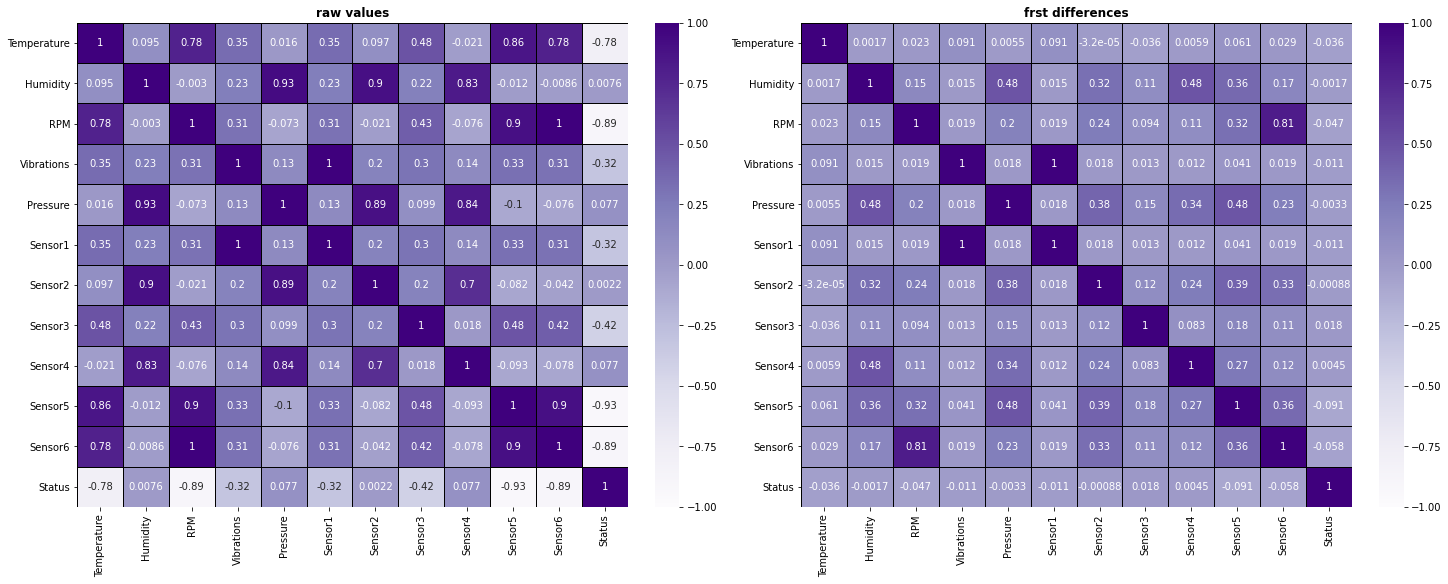

In [18]:
# correlation vs cross-correlation (Pearson)
fig, (ax1,ax2) = plt.subplots(figsize=(20,8), ncols=2, constrained_layout=True)
plot_correlation_matrix(raw, method = 'pearson', title='raw values', ax=ax1)
plot_correlation_matrix(raw.diff(), method = 'pearson', title='frst differences', ax=ax2)

#### iv) Drop columns

In [19]:
from ml_pipeline.dataset import drop_columns
# this function can be used to drop columns
drop_columns(raw, to_drop = ['Sensor1'])

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status
Time,,,,,,,,,,,
2020-01-01 00:00:00,31.11716,74.1715,72.0,16.81,76.0,203.793426,0.582975,799.101683,7.149643,15.842287,0.0
2020-01-01 00:01:00,31.11716,74.1715,72.0,16.81,76.0,203.793426,0.582975,799.101683,7.149643,15.842287,0.0
2020-01-01 00:02:00,32.08894,74.0803,72.0,17.08,76.0,204.411886,0.575500,834.897700,7.089729,15.739743,0.0
2020-01-01 00:03:00,31.67221,73.9272,72.0,15.79,76.0,204.363994,0.575500,805.467950,7.135375,15.731202,0.0
2020-01-01 00:04:00,31.95202,73.7603,72.0,16.84,76.0,203.947834,0.584042,822.142650,7.092582,15.773928,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:55:00,33.52116,0.0000,72.0,23.00,11.0,17.777731,0.372634,73.096240,7.115405,16.115723,0.0
2020-01-31 23:56:00,33.17696,0.0000,72.0,23.38,11.0,17.769158,0.361957,71.922282,7.123963,16.098630,0.0
2020-01-31 23:57:00,32.88938,0.0000,72.0,24.77,11.0,17.822902,0.352347,67.741018,7.103994,16.115723,0.0


### Time as features


In [20]:
from ml_pipeline.dataset import add_time_features

raw_w_time = add_time_features(raw)

time_features = ['month', 'day_of_week', 'hour', 'hours_since']

In [21]:
raw_w_time.nunique()[time_features]

month           1
day_of_week     7
hour           24
hours_since    13
dtype: int64

In [22]:
raw_w_time.corr()[time_features].drop(time_features)

,month,day_of_week,hour,hours_since
Temperature,NaN,0.058769,0.024095,0.026576
Humidity,NaN,0.022842,-0.054371,0.017044
RPM,NaN,-0.152014,0.037462,-0.019908
Vibrations,NaN,-0.038657,-0.030573,0.059453
Pressure,NaN,0.044866,-0.057322,0.019387
Sensor1,NaN,-0.038657,-0.030573,0.059453
Sensor2,NaN,0.004770,-0.078122,0.019562
Sensor3,NaN,0.186559,0.016828,0.037019
Sensor4,NaN,0.011721,-0.041639,0.038513
Sensor5,NaN,-0.055239,0.062619,-0.001676


In [23]:
# temperature is much lower on Mondays, but that is when the breakdown occurs
# although Vibrations are much lower on Saturday
raw_w_time.groupby(raw_w_time['day_of_week']).mean().round(2)

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status,month,hour,hours_since
day_of_week,,,,,,,,,,,,,,,
0,19.92,69.17,60.36,61.01,74.99,2.87,202.14,0.35,938.09,4.93,13.26,0.38,1.0,11.5,6.0
1,26.27,62.50,70.73,57.93,68.79,2.73,186.35,0.39,862.16,6.65,15.47,0.00,1.0,11.5,6.0
2,33.63,62.39,72.01,47.41,65.65,2.23,183.60,0.50,809.68,6.99,15.88,0.00,1.0,11.5,6.0
3,33.47,68.68,71.80,55.17,73.82,2.60,187.07,0.47,946.72,6.96,15.82,0.00,1.0,11.5,6.0
4,31.10,57.16,72.28,44.38,64.87,2.09,169.12,0.46,756.40,7.03,15.91,0.00,1.0,11.5,6.0
5,25.71,68.40,58.54,29.18,74.56,1.37,201.56,0.45,906.36,5.37,12.91,0.49,1.0,11.5,6.0
6,24.67,69.27,55.20,71.50,74.77,3.36,202.28,0.53,942.62,5.19,12.15,0.54,1.0,11.5,6.0


In [24]:
# if we look at just Normal operations, we still see lower temperature on Mondays
# but now because we excluded some rows, we have an hour imbalance 
only_normal = raw[raw.Status==0]
only_normal.groupby(only_normal['day_of_week']).mean().round(2)

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status,month,hour,hours_since
day_of_week,,,,,,,,,,,,,,,
0,24.51,70.13,68.13,75.07,75.19,3.53,202.14,0.40,943.17,6.06,14.92,0.0,1.0,12.95,5.80
1,26.27,62.50,70.73,57.93,68.79,2.73,186.35,0.39,862.16,6.65,15.47,0.0,1.0,11.50,6.00
2,33.63,62.39,72.01,47.41,65.65,2.23,183.60,0.50,809.68,6.99,15.88,0.0,1.0,11.50,6.00
3,33.47,68.68,71.80,55.17,73.82,2.60,187.07,0.47,946.72,6.96,15.82,0.0,1.0,11.50,6.00
4,31.10,57.16,72.28,44.38,64.87,2.09,169.12,0.46,756.40,7.03,15.91,0.0,1.0,11.50,6.00
5,33.97,69.03,71.92,38.47,74.45,1.81,201.56,0.54,900.11,7.11,15.87,0.0,1.0,11.42,6.04
6,33.86,70.86,71.99,98.15,75.00,4.62,202.28,0.67,946.66,7.12,15.86,0.0,1.0,11.17,5.87


In [25]:
# because we included only Normal status rows, we now have an hour imbalance 
# which results in Monday having an over-representation of colder times of day
xtab = pd.crosstab(only_normal['hour'],
                    only_normal['day_of_week'])
xtab.index.name = 'hour'; xtab.columns.name = 'day'
xtab

day,0,1,2,3,4,5,6
hour,,,,,,,
0,120,240,300,300,300,210,180
1,120,240,300,300,300,180,180
2,120,240,300,300,300,180,180
3,120,240,300,300,300,180,180
4,159,240,300,300,300,180,180
5,180,240,300,300,300,180,180
6,180,240,300,300,300,180,180
7,180,240,300,300,300,180,180
8,180,240,300,300,300,180,180


In [26]:
# we can also look at distribution by hour, we see vibrations lowest as 17:00
only_normal.groupby(only_normal['hour']).mean().round(2)

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status,month,day_of_week,hours_since
hour,,,,,,,,,,,,,,,
0,32.00,67.68,71.88,60.40,71.87,2.84,192.60,0.48,886.43,6.99,15.83,0.0,1.0,3.07,12.0
1,33.04,66.46,71.70,64.84,71.93,3.05,194.23,0.52,894.63,7.02,15.81,0.0,1.0,3.04,11.0
2,33.11,66.61,71.52,66.20,72.05,3.12,193.89,0.49,898.59,6.97,15.76,0.0,1.0,3.04,10.0
3,32.35,66.72,71.42,61.68,72.11,2.90,193.98,0.52,901.78,6.89,15.73,0.0,1.0,3.04,9.0
4,31.06,66.07,69.96,64.03,71.78,3.01,192.55,0.49,890.99,6.71,15.43,0.0,1.0,2.97,8.0
5,30.46,65.22,69.13,64.42,71.48,3.03,191.48,0.46,867.75,6.66,15.26,0.0,1.0,2.93,7.0
6,29.74,65.71,69.74,63.42,70.47,2.98,188.32,0.47,870.69,6.72,15.40,0.0,1.0,2.93,6.0
7,30.40,65.76,70.58,59.98,70.35,2.82,188.66,0.48,872.39,6.78,15.62,0.0,1.0,2.93,5.0
8,31.01,65.73,70.88,57.49,70.41,2.71,188.64,0.47,871.61,6.83,15.62,0.0,1.0,2.93,4.0


In [27]:
# we can also look at distribution by hour since, hich 
only_normal.groupby(only_normal['hours_since']).mean().round(2)

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status,month,day_of_week,hour
hours_since,,,,,,,,,,,,,,,
0,31.05,65.28,72.13,53.96,70.56,2.54,188.31,0.45,866.78,6.88,15.85,0.0,1.0,2.93,12.00
1,30.86,65.14,71.78,52.39,70.35,2.47,187.63,0.47,864.03,6.85,15.77,0.0,1.0,2.91,12.01
2,30.20,64.85,71.71,53.81,70.19,2.53,188.53,0.47,862.92,6.78,15.73,0.0,1.0,2.88,12.04
3,30.63,64.67,71.51,51.46,70.04,2.42,186.80,0.46,862.85,6.80,15.71,0.0,1.0,2.88,12.05
4,30.45,64.59,71.12,51.79,70.12,2.44,187.46,0.48,862.96,6.81,15.63,0.0,1.0,2.88,12.07
5,30.23,64.47,70.76,52.46,69.88,2.47,185.78,0.48,862.23,6.78,15.58,0.0,1.0,2.88,12.09
6,30.48,64.74,70.57,56.08,70.00,2.64,185.95,0.48,867.74,6.81,15.55,0.0,1.0,2.88,12.11
7,31.13,64.59,70.64,62.79,70.57,2.95,188.03,0.48,868.50,6.82,15.56,0.0,1.0,2.88,12.12
8,31.23,64.99,71.06,63.80,70.59,3.00,189.02,0.50,877.05,6.85,15.65,0.0,1.0,2.89,12.19
